## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.spatial import Voronoi, voronoi_plot_2d
from tqdm import tqdm

## Generate dataset

In [2]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=6, n_features=2, random_state=67)

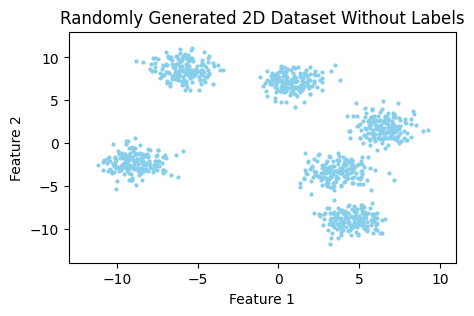

In [3]:
plt.figure(figsize=(5,3)) 
plt.scatter(X[:, 0], X[:, 1], 4, marker='o', c='skyblue')
plt.title("Randomly Generated 2D Dataset Without Labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.show()

## Sklearn KMeans

In [4]:
kmeans = KMeans(n_clusters=6, random_state=67)
km_labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

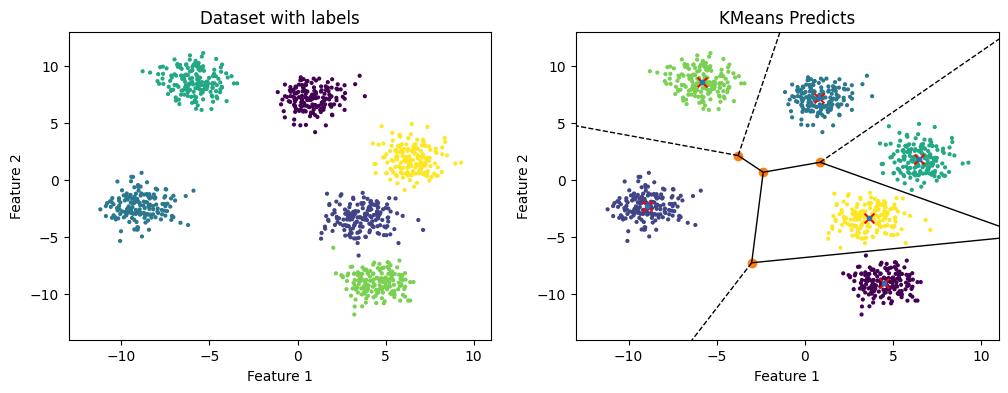

In [5]:
plt.figure(figsize=(12,4)) 
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], 4, c=y)
plt.title("Dataset with labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
vor = Voronoi(centers)
fig = voronoi_plot_2d(vor, plt.subplot(1, 2, 2))
plt.scatter(X[:, 0], X[:, 1], 4, c=km_labels) 
plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', s=50)
plt.title("KMeans Predicts")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.show()

## My KMeans

### Functions

In [6]:
def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for each iteration.
    
    Args:
        X (ndarray): (m, n) Input values      
        centroids (ndarray): k centroids
    
    Returns:
        idx (array_like): (m,) closest centroids
    
    """

    # Set K as number of centroids
    K = centroids.shape[0]
    
    # Initialize the labels array to 0
    label = np.zeros(X.shape[0], dtype=int)

    # For each sample in the dataset
    for sample in range(len(X)):
        distance = []
        # Take every centroid
        for centroid in range(len(centroids)):
            # Compute Euclidean norm between a specific sample and a centroid
            norm = np.linalg.norm(X[sample] - centroids[centroid])
            distance.append(norm)
        
        # Assign the closest centroid as it's label
        label[sample] = distance.index(min(distance))
    
    return label

In [7]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the data points assigned to each centroid.
    
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each example in X. Concretely, idx[i] contains the index of 
                            the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """
    
    # Number of samples and features
    m, n = X.shape
    
    # Initialize centroids to 0
    centroids = np.zeros((K, n))
    
    # For each centroid
    for k in range(K):   
        # Take all samples assigned to that specific centroid
        points = X[idx == k]
        # Compute their mean
        centroids[k] = np.mean(points, axis=0)
    
    return centroids

In [12]:
def kmeans_on_steroids(X, n_clusters):
    """
    My implementation of the KMeans++ algorithm used as an initialization method for computing the centroids.
    
    Args:
        X (ndarray):   (m, n) Data points
        n_clusters (int):     number of centroids
    
    Returns:
        centroids (ndarray): Initial centroids computed
    """
    # Assign the first centroid to be the first sample from the dataset
    centroids = [X[0]]

    # For each cluster
    for _ in range(1, n_clusters):
        
        # Get the squared distance between that centroid and each sample in the dataset
        squared_distances = np.array([min([np.inner(centroid - sample,centroid - sample) for centroid in centroids]) for sample in X])
        
        # Convert the distances into probabilities that a specific sample could be the center of a new centroid
        proba = squared_distances / squared_distances.sum()
        
        for point, probability in enumerate(proba):
            # Take the point with the maximum probability to be the new centroid and append it to the list
            if probability == proba.max():
                centroid = point
                break
        
        centroids.append(X[centroid])

    return np.array(centroids)

In [9]:
def kmeans(X, n_clusters, iters = 50):
    """
    My implementation of the KMeans algorithm.
    
    Args:
        X (ndarray):   (m, n) Data points
        n_clusters (int):     number of centroids
        iters (int):          Number of iterations to run the KMeans algorithm.
    
    Returns:
        centroids (ndarray):  Computed centroids
        labels (ndarray):     Predicts for each sample in the dataset.
    """
    # Number of samples and features
    m, n = X.shape
    
    # Compute initial position of the centroids
    initial_centroids = kmeans_on_steroids(X, n_clusters)
    
    centroids = initial_centroids   
    labels = np.zeros(m)
    
    # Run K-Means
    for i in tqdm(range(iters), desc="KMeans fit progress : "):
        
        # For each example in X, assign it to the closest centroid
        labels = find_closest_centroids(X, centroids)
            
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, labels, n_clusters)
        
    return centroids, labels

### Implementation

In [13]:
centroids, labels = kmeans(X, 6)

KMeans fit progress : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 55.53it/s]


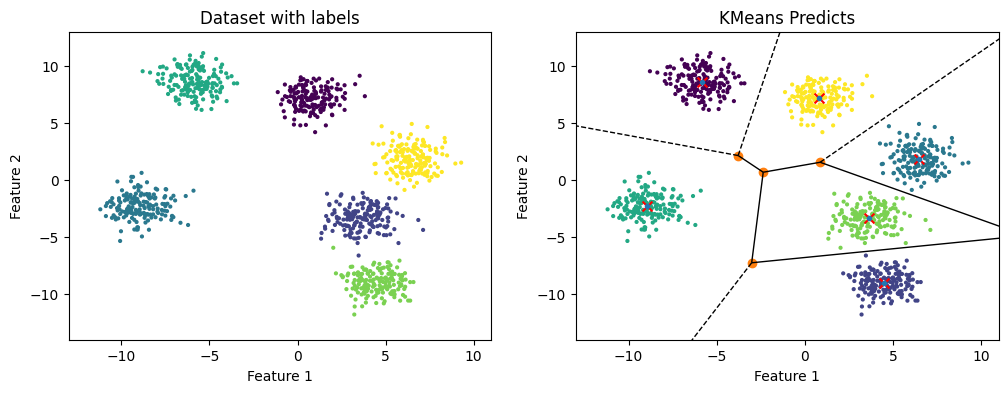

In [16]:
plt.figure(figsize=(12,4)) 
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], 4, c=y)
plt.title("Dataset with labels")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
vor = Voronoi(centroids)
fig = voronoi_plot_2d(vor, plt.subplot(1, 2, 2))
plt.title("KMeans Predicts")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.scatter(X[:, 0], X[:, 1], 4, c=labels) 
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red', s=50)
plt.show()

## Compare results

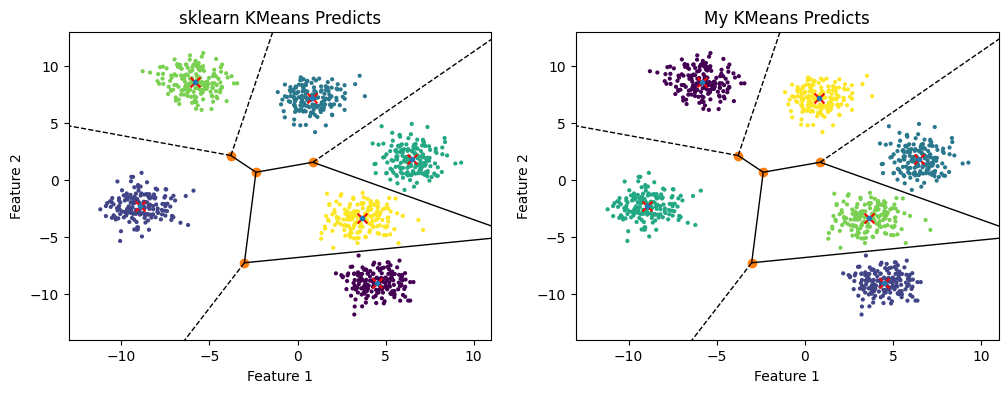

In [17]:
plt.figure(figsize=(12,4)) 
vor = Voronoi(centers)
fig = voronoi_plot_2d(vor, plt.subplot(1, 2, 1))
plt.subplot(1, 2, 1)
plt.title("sklearn KMeans Predicts")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.scatter(X[:, 0], X[:, 1], 4, c=km_labels) 
plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', s=50)
vor = Voronoi(centroids)
fig = voronoi_plot_2d(vor, plt.subplot(1, 2, 2))
plt.subplot(1, 2, 2)
plt.title("My KMeans Predicts")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim([-13, 11])
plt.ylim([-14, 13])
plt.scatter(X[:, 0], X[:, 1], 4, c=labels) 
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red', s=50)
plt.show()